Main resource: https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_7_TRAINING_A_MODEL.md

In [8]:
import flair
import numpy as np
import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
flair.device = device

print(flair.device)

cuda


In [9]:
print(torch.__version__)

1.7.1+cu110


In [10]:
from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

data_folder = '../data/corpuslow_13042021'
column_name_map = {1: "text", 2: "label_topic"}

# 1. get the corpus
corpus: Corpus = CSVClassificationCorpus(data_folder,
                                         column_name_map,
                                         skip_header=True) 

# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

print(label_dict)

2021-04-26 20:51:07,022 Reading data from ..\data\corpuslow_13042021
2021-04-26 20:51:07,023 Train: ..\data\corpuslow_13042021\train.csv
2021-04-26 20:51:07,023 Dev: ..\data\corpuslow_13042021\dev.csv
2021-04-26 20:51:07,024 Test: ..\data\corpuslow_13042021\test.csv
2021-04-26 20:51:07,064 Computing label dictionary. Progress:


100%|██████████████████████████████████████████████████████████████████████████████████| 976/976 [00:01<00:00, 624.81it/s]

2021-04-26 20:51:29,711 [b'0', b'1']
Dictionary with 2 tags: 0, 1


In [11]:
# 3. make a list of word embeddings
word_embeddings = [WordEmbeddings('glove'), FlairEmbeddings('news-forward'), FlairEmbeddings('news-backward')]

# 4. initialize document embedding by passing list of word embeddings
document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=256, bidirectional=True,rnn_type="LSTM")

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)

# 7. start the training
trainer.train('./flair/bilstm_low',
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              train_with_dev=True,
              patience=3,
              max_epochs=10,
              monitor_test=True,
              embeddings_storage_mode='gpu')

2021-04-26 20:51:34,228 ----------------------------------------------------------------------------------------------------
2021-04-26 20:51:34,229 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_features=2048, out_features=300, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_features=2048, out_features=300, bias=True)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=4196, out_features=4196, bias=True)
    (rnn): LSTM(4196, 256,

{'test_score': 0.6606,
 'dev_score_history': [],
 'train_loss_history': [0.7040446804415795,
  0.6426986398235444,
  0.6450454265840592,
  0.6420611316157926,
  0.6235236698581327,
  0.6296196022341328,
  0.6209459497082618,
  0.6186512968232555,
  0.6220770526316858,
  0.6110352191232866],
 'dev_loss_history': []}

2021-04-26 21:01:11,273 ----------------------------------------------------------------------------------------------------
2021-04-26 21:01:11,274 WARNING: No F1 found for test split in this data.
2021-04-26 21:01:11,275 Are you sure you want to plot F1 and not another value?
2021-04-26 21:01:11,275 ----------------------------------------------------------------------------------------------------


No handles with labels found to put in legend.


Loss and F1 plots are saved in flair\bilstm_low\training.png


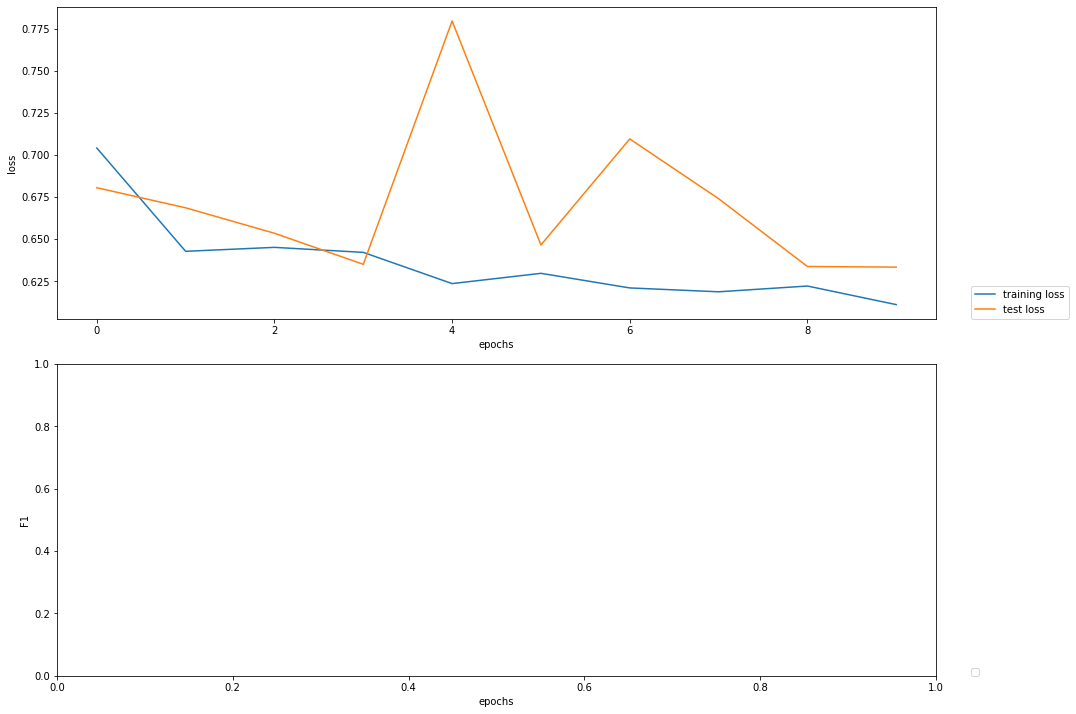

In [12]:
# visualize
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_training_curves('./flair/bilstm_low/loss.tsv')

#This generates PNG plots in the result folder.

In [15]:
test_csv = pd.read_csv('../data/corpuslow_13042021/test.csv')
test_csv.head()

,Unnamed: 0,Response,LowConcrete
0,1000,"1. Phone old friends\n2. Text, video call fami...",1
1,446,Getting back to my activities would be great. ...,0
2,608,I would make a list (mental or on paper) of wh...,0
3,457,Mostly I would paint and play/compose music wh...,1
4,149,"Lately I have been feeling lonely ,, the steps...",0


In [22]:
from flair.data import Sentence

test_data = []
target = []
preds = []

for i, item in test_csv.iterrows():
    test_data.append(Sentence(item.Response))
    target.append(str(item.LowConcrete))
    
classifier.predict(test_data, mini_batch_size=4)

for item in test_data:
    preds.append(item.labels[0].value)

C:\Users\magab\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['1', '0'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


[Text(0, 0.5, '1'), Text(0, 1.5, '0')]

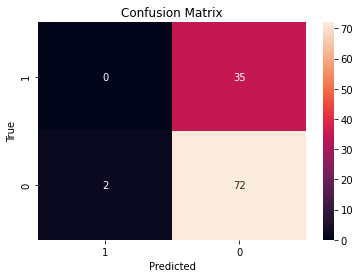

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['1', '0']
cm = confusion_matrix(target, preds, labels)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
from sklearn.metrics import classification_matrix

print(classification_matrix(target,preds))